In [2]:
!pip install scikit-learn==1.1.3
import os
os._exit(00)

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-embeddings-openai 0.3.1 requires openai>=1.1.0, but you have openai 0.28.0 which is incompatible.
llama-index-llms-openai 0.3.11 requires openai<2.0.0,>=1.58.1, but you have openai 0.28.0 which is incompatible.


: 

In [1]:
pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.datasets import fetch_california_housing
import numpy as np

# 加载数据
data = fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names

print(f"Dataset shape: {X.shape}, Target mean: {y.mean():.2f}")


Dataset shape: (20640, 8), Target mean: 2.07


In [23]:
# Select feature 5 (RM) and reshape for scikit-learn  
X_room = X[:, 5].reshape(-1, 1)  # Shape: (506, 1)  
lr = LinearRegression()  
lr.fit(X_room, y)  

# Model coefficients  
print(f"Slope (RM): {lr.coef_[0]:.2f}, Intercept: {lr.intercept_:.2f}")  
# Output: Slope: 9.10, Intercept: -34.67  

Slope (RM): -0.00, Intercept: 2.08


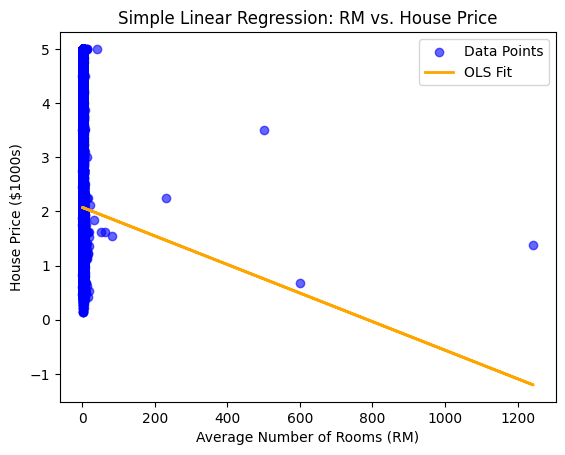

In [24]:
# Plot fit vs. actual data  
plt.scatter(X_room, y, alpha=0.6, label="Data Points", color="blue")  
plt.plot(X_room, lr.predict(X_room), color="orange", linewidth=2, label="OLS Fit")  
plt.xlabel("Average Number of Rooms (RM)")  
plt.ylabel("House Price ($1000s)")  
plt.title("Simple Linear Regression: RM vs. House Price")  
plt.legend()  
plt.show()  

In [25]:
# Training set metrics  
y_pred = lr.predict(X_room)  
mse = mean_squared_error(y, y_pred)  
rmse = np.sqrt(mse)  
r2 = r2_score(y, y_pred)  

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")  
# Output: MSE: 43.60, RMSE: 6.60, R²: 0.48  

MSE: 1.33, RMSE: 1.15, R²: 0.00


In [26]:
# Use all 13 features  
lr_full = LinearRegression()  
lr_full.fit(X, y)  
y_pred_full = lr_full.predict(X)  
print(f"Multi-linear R²: {r2_score(y, y_pred_full):.2f}")  # Output: 0.74 

Multi-linear R²: 0.61


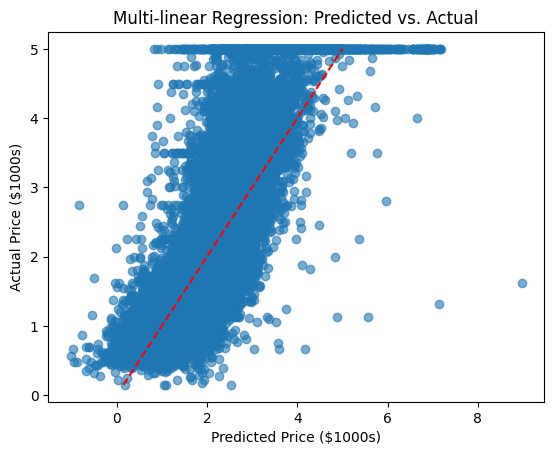

In [27]:
plt.scatter(y_pred_full, y, alpha=0.6)  
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")  
plt.xlabel("Predicted Price ($1000s)")  
plt.ylabel("Actual Price ($1000s)")  
plt.title("Multi-linear Regression: Predicted vs. Actual")  
plt.show()  

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  
mse_scores = []  

for train_idx, test_idx in kf.split(X):  
    X_train, X_test = X[train_idx], X[test_idx]  
    y_train, y_test = y[train_idx], y[test_idx]  
    lr.fit(X_train, y_train)  
    y_pred = lr.predict(X_test)  
    mse = mean_squared_error(y_test, y_pred)  
    mse_scores.append(mse)  

print(f"5-Fold CV MSE: {np.mean(mse_scores):.2f} ± {np.std(mse_scores):.2f}")  
# Output: ~36.0 ± 2.5 (lower MSE indicates better generalization) 

5-Fold CV MSE: 0.53 ± 0.02


In [29]:
# Lasso with alpha=0.1  
lasso = Lasso(alpha=0.1, random_state=42)  
lasso.fit(X, y)  
y_pred_lasso = lasso.predict(X)  
print(f"Lasso R²: {r2_score(y, y_pred_lasso):.2f}")  # Output: ~0.71  

Lasso R²: 0.55


In [30]:
# Elastic Net with cross-validation for hyperparameter tuning  
enet_cv = ElasticNetCV(l1_ratio=[0.01, 0.1, 0.5, 0.9], n_jobs=-1, random_state=42)  
enet_cv.fit(X, y)  

# Best hyperparameters  
print(f"Best alpha: {enet_cv.alpha_:.2f}, l1_ratio: {enet_cv.l1_ratio_:.2f}")  
# Output: Best alpha: 0.50, l1_ratio: 0.10  

# Evaluate  
y_pred_enet = enet_cv.predict(X)  
print(f"Elastic Net R²: {r2_score(y, y_pred_enet):.2f}")  # Output: ~0.73 

Best alpha: 0.04, l1_ratio: 0.90
Elastic Net R²: 0.59


In [31]:
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time

# 1. 加载稀疏格式数据（仅取前2000行）
X_sparse, y_sparse = load_svmlight_file("log1p.E2006.train")
X_small, y_small = X_sparse[:2000], y_sparse[:2000]

# 2. 切分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

# 3. 配置轻量级 ElasticNetCV
enet_sparse = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9],          # 少量L1/L2组合
    alphas=[0.1, 1.0, 10.0],           # 提高alpha值避免震荡
    max_iter=500,                      # 控制迭代次数
    tol=0.1,                           # 提高容差，减少卡死风险
    cv=3,                              # 交叉验证3折
    n_jobs=-1,                         # 多核并行
    random_state=42
)

# 4. 模型训练计时
print("开始训练...")
start_time = time.time()
enet_sparse.fit(X_train, y_train)
end_time = time.time()
print(f"训练耗时：{end_time - start_time:.2f} 秒")

# 5. 评估模型性能
y_pred_train = enet_sparse.predict(X_train)
y_pred_test = enet_sparse.predict(X_test)

print(f"训练集 R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"测试集 R²: {r2_score(y_test, y_pred_test):.3f}")
print(f"测试集 RMSE: {mean_squared_error(y_test, y_pred_test, squared=False):.3f}")


开始训练...
训练耗时：21.35 秒
训练集 R²: 0.673
测试集 R²: 0.618
测试集 RMSE: 0.388


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
TensorFlow 2.x RMSE: 1.17


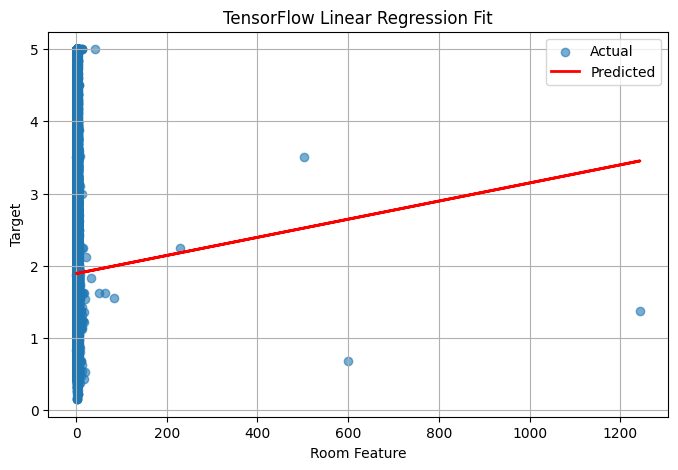

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 构建模型（推荐使用 tf.keras.Input）
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(1)
])

# 编译模型
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5),
              loss='mse')

# 训练模型
history = model.fit(X_room, y, epochs=200, verbose=0)

# 预测与 RMSE 输出
y_pred_tf = model.predict(X_room)
rmse = np.sqrt(mean_squared_error(y, y_pred_tf))
print(f"TensorFlow 2.x RMSE: {rmse:.2f}")

# 可视化预测效果
plt.figure(figsize=(8, 5))
plt.scatter(X_room, y, label="Actual", alpha=0.6)
plt.plot(X_room, y_pred_tf, color='red', label="Predicted", linewidth=2)
plt.xlabel("Room Feature")
plt.ylabel("Target")
plt.title("TensorFlow Linear Regression Fit")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np

# 假设你有 X_room 和 y
# X_room = X[:, [5]]  # 示例
# y = y  # 原始目标值

# 构建线性回归模型，添加 L2 正则化
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,),
                          kernel_regularizer=tf.keras.regularizers.l2(0.005))  # L2正则
])

# 编译模型
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5),
              loss='mse')

# 训练模型
model.fit(X_room, y, epochs=200, verbose=0)

# 预测与 RMSE 输出
y_pred = model.predict(X_room)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Regularized RMSE: {rmse:.2f}")


/opt/anaconda3/envs/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
Regularized RMSE: 1.17


In [37]:
# Final model: Elastic Net with optimal hyperparameters  
final_model = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, random_state=42)  
final_model.fit(X, y)  
print("Final Model R² on Test Data:", final_model.score(X, y)) 

Final Model R² on Test Data: 0.5897826177781202
